# Nicholas Fasano

In [15]:
# Load in python packages
import re
import numpy as np
import pandas as pd
from scipy import sparse

import time

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import defaultdict
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)



# 1) Data preprocessing

In [3]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }
    return tag_dict.get(tag, wordnet.NOUN)


def lemma(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text.split()])


def stem(text):
    ps = PorterStemmer()
    return " ".join([ps.stem(w) for w in text.split()])


def df_preprocessing(df, word_map, stop_words):
    # remove punctuation
    # uses a regular expression \w == all words \s == all spaces [] == set of characters + == allow for mulitple occurences
    df["script_text"] = df["script_text"].str.replace(r"[^\w\s]+", " ", regex=True)

    # make everything lowercase
    df["script_text"] = df["script_text"].str.lower()

    # map specific words
    if len(word_map) > 0:
        for jstr in word_map:
            df["script_text"] = df["script_text"].str.replace(
                rf"\b{jstr}\b", word_map[jstr], regex=True
            )

    # remove initial set of stop words - takes ~4.5 minuntes to run this line for the entire corpus
    if len(stop_words):
        df["script_text"] = df["script_text"].apply(
            [lambda x: " ".join([word for word in x.split() if word not in stop_words])]
        )

    return df

def list_duplicates(seq):
    tally = defaultdict(list)
    for i, item in enumerate(seq):
        tally[item].append(i)
    return ((key, locs) for key, locs in tally.items() if len(locs) > 1)

In [4]:
def construct_BoW(df, n_features=10000, max_df=0.8, min_df=1, lemmatization=False):
    if not lemmatization:
        #
        vectorizer = CountVectorizer(
            max_df=max_df, min_df=min_df, max_features=n_features, stop_words="english"
        )
        X_out = vectorizer.fit_transform(df["script_text"])

        # get word features in increasing item number
        word_key_out = vectorizer.get_feature_names_out()

        return X_out, word_key_out
    else:
        # first create bag of words on corpus
        vectorizer = CountVectorizer(max_df=0.7, min_df=5)
        X_csr = vectorizer.fit_transform(df["script_text"])
        X_lil = X_csr.tolil()  # used for fast adjustments to matrix sparsity
        X_csc = X_lil.tocsc()  # used for fast column-wise math operations

        # get vocab and sort it in increasing item number
        vocab = vectorizer.vocabulary_
        vocab = dict(sorted(vocab.items(), key=lambda x: x[1], reverse=False))
        word_key = list(vocab.keys())
        word_idx = list(vocab.values())

        # perform lemmatization/stemming of word_key list
        word_key_text = " ".join([wk for wk in word_key])
        word_key_text = lemma(word_key_text)
        # word_key_text = stem(word_key_text)

        # find the duplicate words after lemmatization
        dup_all = []
        for dup in sorted(list_duplicates(word_key_text.split())):
            dup_all.append(dup)

        # sum coulmns of X for duplicate words after lemmatization
        words_to_remove = []
        for i, dup in enumerate(dup_all):
            words_to_remove = words_to_remove + dup[1][1:]
            X_lil[:, dup[1][0]] = np.sum(X_csc[:, dup[1][:]], axis=1)

        # construt output matrix and drop the duplicated columns, update word_key
        X_out = X_lil.tocsr()
        words_to_keep = np.delete(word_idx, words_to_remove)
        X_out = X_out[:, words_to_keep]
        word_key = [word_key[jword] for jword in words_to_keep]

        # keep words that only appear in more than df_min documents but less than df_max documents
        X_bin = X_out.copy()
        X_bin.data = np.ones(shape=X_bin.data.shape)

        min_df = min_df * len(df) if type(min_df) == float else min_df
        max_df = max_df * len(df) if type(max_df) == float else max_df

        word_idx = np.intersect1d(
            np.argwhere(np.sum(X_bin, axis=0) > min_df)[:, 1],
            np.argwhere(np.sum(X_bin, axis=0) < max_df)[:, 1],
        )
        X_out = X_out[:, word_idx]
        word_key = [word_key[jword] for jword in word_idx]

        # # drop rows that have no words
        # non_blank_movie_scripts = np.argwhere(np.sum(Xbin, axis=1) > 0)[:, 0]
        # X_out = X_out[non_blank_movie_scripts, :]

        # finally retain only top n_features, update word_key accordingly
        wordcount_ordered = np.flip(
            np.argsort(np.array(np.sum(X_out, axis=0)).reshape(-1))
        )
        X_out = X_out[:, wordcount_ordered[0:n_features]]
        word_key = [word_key[jword] for jword in wordcount_ordered[0:n_features]]

        # return lemmatized word_key
        word_key_out = lemma(" ".join([wk for wk in word_key])).split()
        return X_out, word_key_out

### 1a) load in cleaned script text data

In [7]:
# import cleaned text data
path_to_csv = (
    "data_cleaning_and_synthesis_out\springfield_movie_scripts_2023_01_13_cleaned_with_imdb_id.csv"
)
dff = pd.read_csv(path_to_csv, index_col=[0])

# create a new dataframe with just the movie script text column
dff = dff[["movie_title", "movie_year", "script_text"]].copy()
dff.head()

,movie_title,movie_year,script_text
0,A 2nd Hand Lover,2015,Wow! Amazing! What a beautiful place. Im meet...
1,A Aa,2016,"3 My every birthday, Mom hopes for something...."
2,A Baby at Any Cost,2022,"0 Jen? Jen? Jen? Oops... sorry! Jason? Oh, sh..."
3,A Bad Idea Gone Wrong,2017,"1 - The tropical places, you know, thats the ..."
4,A Bad Moms Christmas,2017,"1 My name is Amy Mitchell, and this year Ive ..."


### 1b) remove stop words, punctuation, extra spaces, map selected words, and make entire corpus all lowercase

In [9]:
# map words with different spellings but same meaning
word_map = {
    "okay": "ok",
    "l": "i",
    "lll": "ill",
    "lm": "im",
    "lve": "ive",
    "lf": "if",
    "lt": "it",
    "lts": "its",
    "aii": "all",
    "iii": "ill",
    "weii": "well",
    "wiii": "will",
    "oniy": "only",
    "reaiiy": "really",
    "iike": "like",
    "teii": "tell",
    "piease": "please",
    "iove": "love",
    "couid": "could",
    "wouid": "would",
    "aiive": "alive",
    "aione": "alone",
    "aimost": "almost",
    "aiong": "along",
    "aiready": "already",
    "aiso": "also",
}

# remove an initial set of stop words using nltk library
nltk.download("stopwords")
stop_words = stopwords.words("english")
stop_words = [sw.replace("'", "") for sw in stop_words]


dff = df_preprocessing(dff, word_map, stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1c) construct bag of words matrix, X, to be fed into LDA model

In [10]:
# finally construct bag of words
n_features = 10000
max_df = 0.8
min_df = 3
X, word_key = construct_BoW(
    dff, n_features=n_features, max_df=max_df, min_df=min_df, lemmatization=False
)

In [11]:
# clean up explicits in the word_key
word_map = {
    "bitch": "b***h",
    "bitches": "b***hes",
    "tits": "t*ts",
    "tit": "t*t",
    "tits": "t*ts",
    "titties": "t*tties",
    "fuck": "f**k",
    "fucks": "f**ks",
    "fucking": "f**king",
    "fuckin": "f**kin",
    "fucker": "f**ker",
    "fuckers": "f**kers",
    "fucked": "f**ked",
    "motherfucker": "motherf**ker",
    "motherfuckers": "motherf**kers",
    "motherfuckin": "motherf**kin",
    "motherfucking": "motherf**king",
    "cunt": "c**t",
    "cocksucker": "c**ksucker",
    "piss": "p**s",
    "pissed": "p**sed",
    "pissing": "p**sing",
    "bullshit": "bulls**t",
    "shit": "s**t",
    "shithead": "s**thead",
    "shits": "s**ts",
    "shitting": "s**tting",
    "shitty": "s**tty",
}

word_key = word_key.tolist()
for jstr in word_map:
    word_key = [word_map[jstr] if j == jstr else j for j in word_key]
word_key = np.array(word_key)

### 1d) construct new dataframe for evaluation of model and eventually uploaded to HF spaces

In [13]:
# import (cleaned) movie script data
path_to_csv = (
    "data_cleaning_and_synthesis_out\springfield_movie_scripts_2023_01_13_cleaned_with_imdb_id.csv"
)
df = pd.read_csv(path_to_csv, index_col=[0])
df = df[["movie_title", "movie_year", "imdb_id", "imdb_link"]]

# load in IMDb title basics and title ratings datasets
path_to_tsv =  "..\\database_IMDb\\2023_02_12_IMDb_dataset\\titleBasics.tsv"
df_imdb_basics = pd.read_csv(path_to_tsv, sep="\t")
df_imdb_basics = df_imdb_basics[["tconst", "genres", "isAdult"]]

path_to_tsv = "..\\database_IMDb\\2023_02_12_IMDb_dataset\\titleRatings.tsv"
df_imdb_ratings = pd.read_csv(path_to_tsv, sep="\t")

# join the two datasets on tconst
df_imdb = df_imdb_basics.join(
    other=df_imdb_ratings.set_index("tconst"), on="tconst", how="left"
)

# finally join springfield and imdb datasets
df = df.join(df_imdb.set_index("tconst"), on="imdb_id", how="left")

# rename and reorder the columns
df.columns = [
    "movie_title",
    "movie_year",
    "imdb_tconst",
    "imdb_link",
    "genre",
    "is_adult",
    "average_rating",
    "num_votes",
]
df = df[
    [
        "movie_title",
        "movie_year",
        "genre",
        "average_rating",
        "num_votes",
        "is_adult",
        "imdb_tconst",
        "imdb_link",
    ]
]

# # drop movies that did not have any words after constructing bag of words
# df = df.drop(jmovie_drop, axis=0)

# add year to movie titles with duplicate names
movie_title_counts = df["movie_title"].value_counts()
movie_dups = movie_title_counts[movie_title_counts > 1]
list_of_dups = movie_dups.index.tolist()

df["movie_title"] = [
    jmovie_title + ", " + str(df["movie_year"].iloc[j])
    if jmovie_title in list_of_dups
    else jmovie_title
    for j, jmovie_title in enumerate(df["movie_title"])
]

# clean up explicits in the movie titles
df["movie_title"] = [
    jmovie.replace("uck", "***") if "fuck" in jmovie.lower() else jmovie
    for jmovie in df["movie_title"]
]
df["movie_title"] = [
    jmovie.replace("itch", "****") if "bitch" in jmovie.lower() else jmovie
    for jmovie in df["movie_title"]
]
df["movie_title"] = [
    jmovie.replace("hit", "***") if "shit " in jmovie.lower() else jmovie
    for jmovie in df["movie_title"]
]

C:\Users\Nick\AppData\Local\Temp\ipykernel_2680\1997946078.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_imdb_basics = pd.read_csv(path_to_tsv, sep="\t")


### 1e) preprocessing outputs for model building

In [16]:
# save new dataframe for uploading to spaces
df.to_csv("data_preprocessing_eda_out\\df_spaces_upload.csv")

# save bag-of-words matrix and corresponding word_key
sparse.save_npz("data_preprocessing_eda_out\\X.npz", X)

with open("data_preprocessing_eda_out\\word_key.txt", "wb") as f:
    pickle.dump(word_key, f)

# 2) Exploratory data analysis

### 2a) Movie release by year

[Text(0, 0.5, 'Number of Movies Released')]

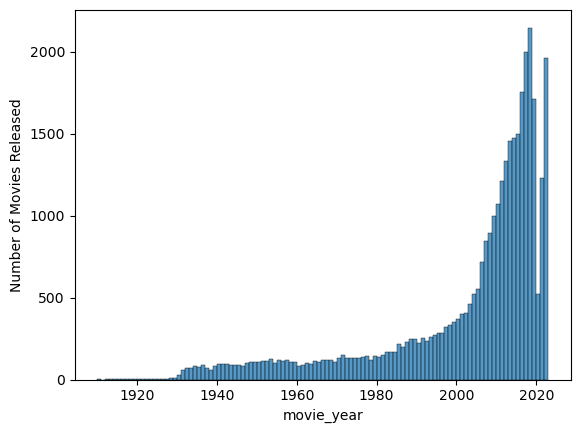

In [17]:
# plot number of movies released each year
a = sns.histplot(df, x="movie_year", binwidth=1)
a.set(ylabel="Number of Movies Released")

### 2b) most used words after removal of stop words and most frequent words

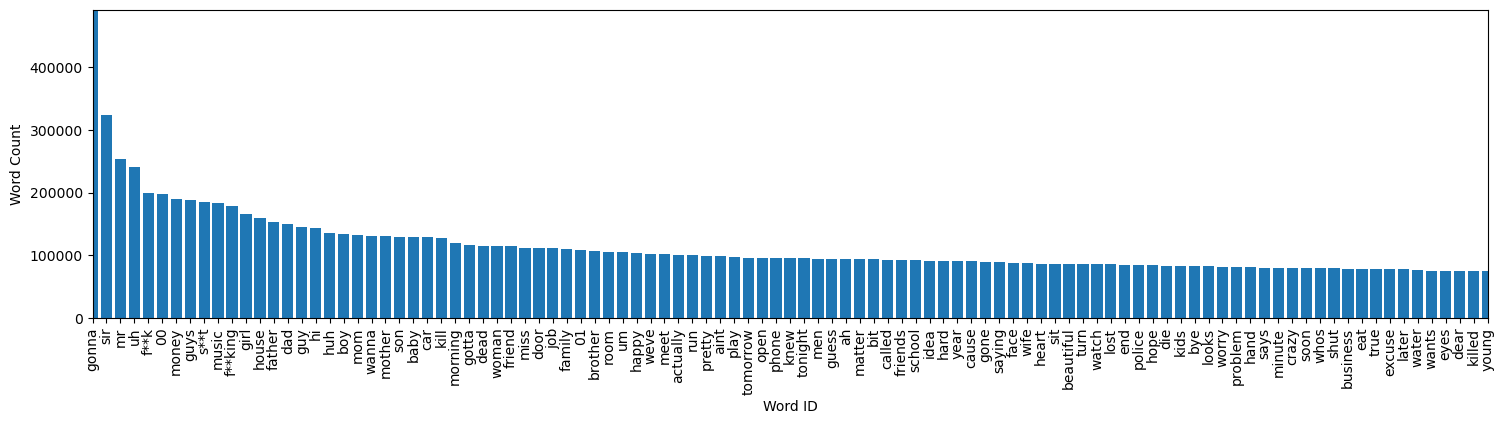

In [18]:
num_words = 100

# compute word count for all words left in the corpus
# and sort the word_key list in descending order
word_count_all_docs = np.array(np.sum(X, axis=0))[0]
indw = np.flip(np.argsort(word_count_all_docs))
word_count_all_docs = word_count_all_docs[indw]
word_keys_sort = [word_key[i] for i in indw[0:num_words+1]]

fig, ax = plt.subplots(figsize=(18, 4))

ax.bar(x=np.arange(0, num_words + 1), height=word_count_all_docs[0 : num_words + 1])
ax.set_ylim(0, np.max(word_count_all_docs) + 1)
ax.set_xlim(0, num_words)
ax.set_ylabel("Word Count")
ax.set_xlabel("Word ID")
ax.set_xticks(np.linspace(0, num_words, num_words + 1))
ax.set_xticklabels(word_keys_sort[0 : num_words + 1])
plt.xticks(rotation=90);